In [ ]:
# #This specific version of torchvision is needed to download the mnist set
# !pip3 install torch torchvision

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
from torchvision import datasets
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np
from tqdm import trange

In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

# Dataset Preparation

The models were evaluated using the MNIST dataset. The MNIST dataset is a widely used benchmark dataset consisting of 28x28 grayscale images of handwritten digits ranging from 0 to 9.

For this evaluation, a batch size of 64 was used, allowing the model to process 64 images simultaneously during both training and evaluation phases.

In [ ]:
# Hyperparameters
batch_size = 64
learning_rate = 1e-3
num_epochs = 10
noise_factor = 1.5
criterion = nn.MSELoss()

In [ ]:
# Load and preprocess the MNIST dataset
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
])

train_dataset = torchvision.datasets.MNIST(root='./data', train=True, transform=transform, download=True)
test_dataset = torchvision.datasets.MNIST(root='./data', train=False, transform=transform, download=True)

train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False)



# Linear Autoencoder

In [ ]:
class DeepLinearAutoencoder(nn.Module):
    def __init__(self):
        super(DeepLinearAutoencoder, self).__init__()

        # Encoder
        self.encoder = nn.Sequential(
            nn.Linear(28 * 28, 512),
            nn.Linear(512, 256),
            nn.Linear(256, 128),
            nn.Linear(128, 64),
            nn.Linear(64, 16),
            # nn.Linear(16, 3)
        )
        # Decoder
        self.decoder = nn.Sequential(
            # nn.Linear(3, 16),  # Increase latent code size
            nn.Linear(16, 64),
            nn.Linear(64, 128),
            nn.Linear(128, 256),
            nn.Linear(256, 512),
            nn.Linear(512, 28 * 28),
            nn.Sigmoid()  # Use sigmoid activation to output values between 0 and 1
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x


In [ ]:
class LinearAutoencoder(nn.Module):
    def __init__(self):
        super(LinearAutoencoder, self).__init__()

        # Encoder
        self.encoder = nn.Sequential(
            nn.Linear(28 * 28, 128),
            nn.Linear(128, 64),
            nn.Linear(64, 32),
            nn.Linear(32, 16),
            nn.Linear(16, 8)  # Larger latent code
        )

        # Decoder
        self.decoder = nn.Sequential(
            nn.Linear(8, 16),
            nn.Linear(16, 32),
            nn.Linear(32, 64),
            nn.Linear(64, 128),
            nn.Linear(128, 28 * 28),
            nn.Sigmoid()  # Use sigmoid activation for output values ​​between 0 and 1
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x


In [ ]:
def train(num_epochs, criterion, optimizer, model):

  for epoch in range(num_epochs):
    for data in train_loader:
        img, _ = data
        img = img.view(img.size(0), -1)
        output = model(img)
        loss = criterion(output, img)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')

In [ ]:
def reconstruct():
  with torch.no_grad():
    for data in test_loader:
        img, _ = data
        img = img.view(img.size(0), -1)
        output = model(img)

        # Plotting the first 8 test images and their reconstructions
        fig, axes = plt.subplots( 2, 8, figsize=(12, 3))
        for i in range(8):
            axes[0, i].imshow(img[i].view(28, 28).numpy(), cmap='gray')
            axes[1, i].imshow(output[i].view(28, 28).numpy(), cmap='gray')
            axes[0, i].axis('off')
            axes[1, i].axis('off')
        plt.show()
        break

Train the model with deep linear autoencoder

Epoch [1/10], Loss: 0.7758
Epoch [2/10], Loss: 0.8163
Epoch [3/10], Loss: 0.8359
Epoch [4/10], Loss: 0.8167
Epoch [5/10], Loss: 0.8653
Epoch [6/10], Loss: 0.8268
Epoch [7/10], Loss: 0.7970
Epoch [8/10], Loss: 0.7897
Epoch [9/10], Loss: 0.8262
Epoch [10/10], Loss: 0.8977


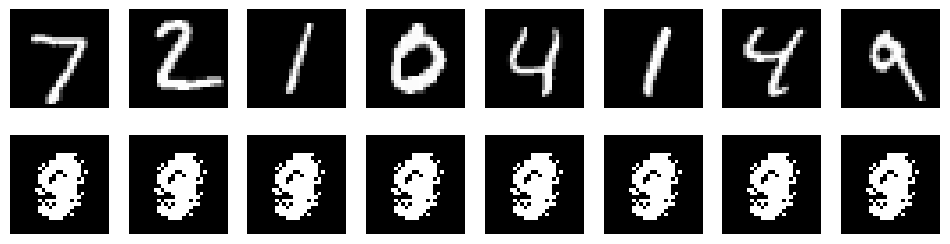

In [ ]:
model = DeepLinearAutoencoder()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
train(num_epochs, criterion, optimizer, model)
reconstruct()

Train the model with a simple linear architecture, and higth code latent

Epoch [1/10], Loss: 0.6710
Epoch [2/10], Loss: 0.6650
Epoch [3/10], Loss: 0.5910
Epoch [4/10], Loss: 0.6555
Epoch [5/10], Loss: 0.6293
Epoch [6/10], Loss: 0.6359
Epoch [7/10], Loss: 0.6137
Epoch [8/10], Loss: 0.5941
Epoch [9/10], Loss: 0.5832
Epoch [10/10], Loss: 0.5695


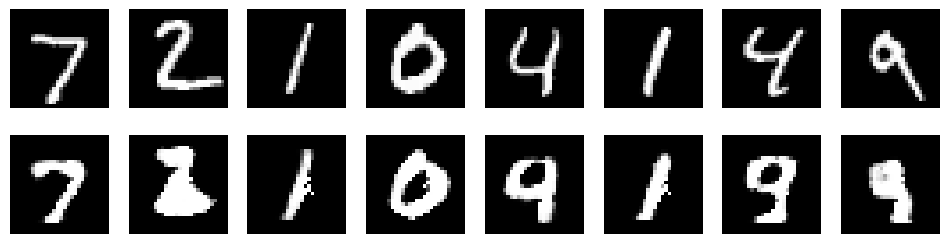

In [ ]:
model = LinearAutoencoder()
optimizer = optim.Adam(model.parameters(), lr=1e-3)
train(num_epochs, criterion, optimizer, model)
reconstruct()

# Denoising Auto-Encoder

In [ ]:
# Function to plot images
def plot_images(images, titles, n_col=10):
    n_row = len(images) // n_col
    fig, axes = plt.subplots(n_row, n_col, figsize=(20, 4))
    for i, (img, title) in enumerate(zip(images, titles)):
        ax = axes[i // n_col, i % n_col]
        ax.imshow(img.squeeze(), cmap='gray')
        ax.set_title(title)
        ax.axis('off')

    plt.show()

In [ ]:
def add_gaussian_noise(x):
    return x + noise_factor * torch.randn_like(x)

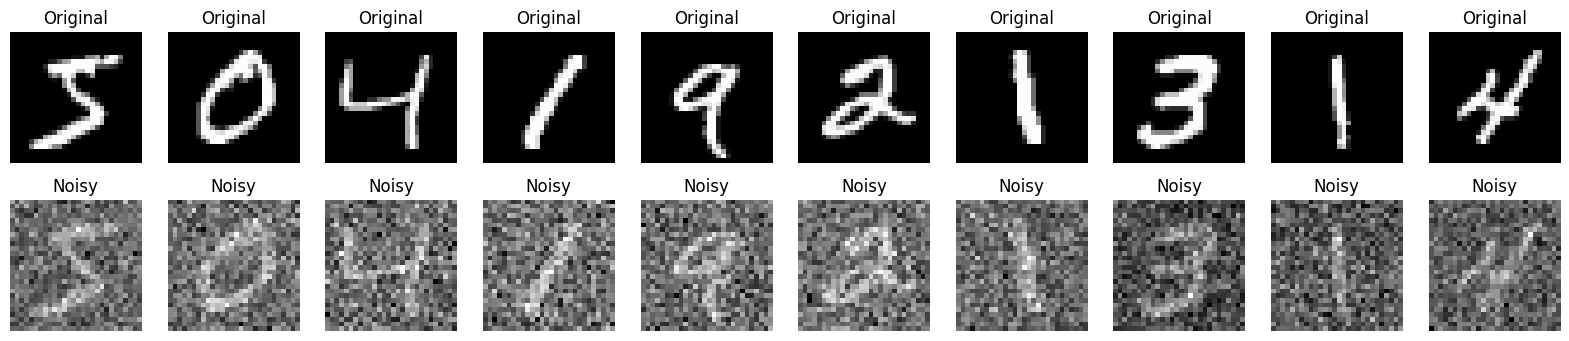

In [ ]:
n_samples = 20
original_images = []
noisy_images = []
titles = []

for i in range(n_samples):
    img, _ = train_dataset[i]
    noisy_img = add_gaussian_noise(img)

    original_images.append(img)
    noisy_images.append(noisy_img)
    titles.append("Original" if i < 10 else "Noisy")

# Combine images for plotting
images_to_plot = original_images[:10] + noisy_images[:10]

# Plot the images
plot_images(images_to_plot, titles)


In [ ]:
class DenoisingAutoencoder(nn.Module):
    def __init__(self):
        super(DenoisingAutoencoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 16, kernel_size=3, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(16, 32, kernel_size=3, stride=2, padding=1),
            nn.ReLU()
        )
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(32, 16, kernel_size=2, stride=2),
            nn.ReLU(),
            nn.ConvTranspose2d(16, 1, kernel_size=2, stride=2),
            nn.Sigmoid()
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

In [ ]:
model = DenoisingAutoencoder().cuda()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

In [ ]:
# Training loop
for epoch in trange(num_epochs):
    model.train()
    for data in train_loader:
        img, _ = data
        img = img.cuda()
        noisy_img = add_gaussian_noise(img).cuda()

        # Forward pass
        outputs = model(noisy_img)
        loss = criterion(outputs, img)
        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')

  0%|          | 0/10 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/autograd/graph.py:744: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:919.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass
 10%|█         | 1/10 [00:17<02:35, 17.29s/it]

Epoch [1/10], Loss: 0.5047


 20%|██        | 2/10 [00:31<02:05, 15.65s/it]

Epoch [2/10], Loss: 0.5103


 30%|███       | 3/10 [00:46<01:47, 15.41s/it]

Epoch [3/10], Loss: 0.5308


 40%|████      | 4/10 [01:01<01:30, 15.04s/it]

Epoch [4/10], Loss: 0.5254


 50%|█████     | 5/10 [01:17<01:16, 15.27s/it]

Epoch [5/10], Loss: 0.5103


 60%|██████    | 6/10 [01:32<01:00, 15.17s/it]

Epoch [6/10], Loss: 0.4958


 70%|███████   | 7/10 [01:47<00:45, 15.18s/it]

Epoch [7/10], Loss: 0.5278


 80%|████████  | 8/10 [02:02<00:30, 15.14s/it]

Epoch [8/10], Loss: 0.5385


 90%|█████████ | 9/10 [02:17<00:15, 15.06s/it]

Epoch [9/10], Loss: 0.4946


100%|██████████| 10/10 [02:33<00:00, 15.36s/it]

Epoch [10/10], Loss: 0.5497


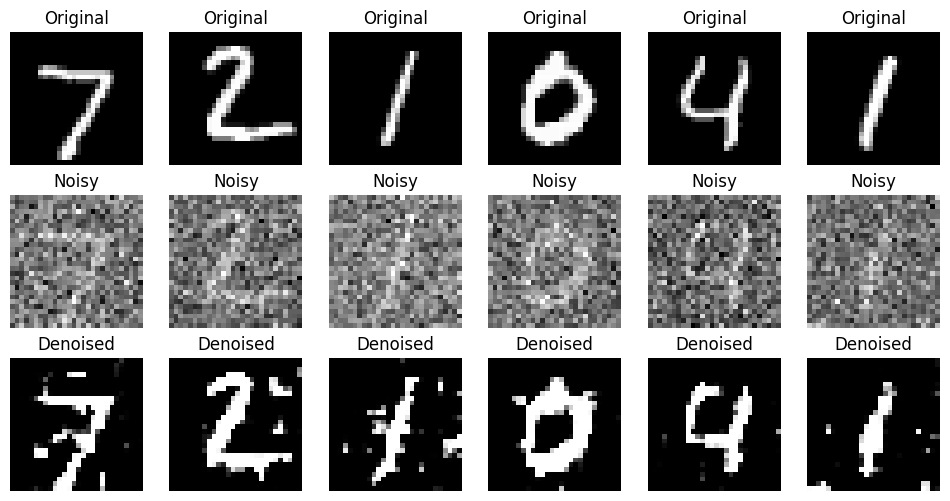

In [ ]:
# Testing loop for MNIST
model.eval()
with torch.no_grad():
    for data in test_loader:
        img, _ = data
        img = img.cuda()
        noisy_img = (img + 2 * torch.randn_like(img)).cuda()
        outputs = model(noisy_img)

        # Visualize the results
        img = img.cpu().numpy()
        noisy_img = noisy_img.cpu().numpy()
        outputs = outputs.cpu().numpy()

        fig, axes = plt.subplots(3, 6, figsize=(12, 6))
        for i in range(6):
            axes[0, i].imshow(img[i].squeeze(), cmap='gray')
            axes[0, i].set_title('Original')
            axes[0, i].axis('off')
            axes[1, i].imshow(noisy_img[i].squeeze(), cmap='gray')
            axes[1, i].set_title('Noisy')
            axes[1, i].axis('off')
            axes[2, i].imshow(outputs[i].squeeze(), cmap='gray')
            axes[2, i].set_title('Denoised')
            axes[2, i].axis('off')
        plt.show()
        break

# Contractive Autoencoder

In [ ]:
# Define the Contractive Autoencoder class
class ContractiveAutoencoder(nn.Module):
    def __init__(self, input_dim, latent_dim, lambda_):
        super(ContractiveAutoencoder, self).__init__()

        self.encoder = nn.Sequential(
            nn.Linear(input_dim, 128),
            nn.ReLU(inplace=True),
            nn.Linear(128, latent_dim),
            nn.ReLU(inplace=True)
        )

        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, 128),
            nn.ReLU(inplace=True),
            nn.Linear(128, input_dim),
            nn.Sigmoid()  # Assuming input data is normalized between 0 and 1
        )

        self.lambda_ = lambda_

    def forward(self, x):
        latent = self.encoder(x)
        reconstruction = self.decoder(latent)
        return reconstruction, latent


    def contractive_loss(self, inputs, reconstruction, latent):
        criterion = nn.MSELoss()
        mse_loss = criterion(reconstruction, inputs)

        # Compute the Jacobian matrix J with respect to the latent representation
        latent_grad = torch.autograd.grad(outputs=latent, inputs=inputs,
                                          grad_outputs=torch.ones_like(latent),
                                          create_graph=True, retain_graph=True, only_inputs=True)[0]

        # Compute the Frobenius norm of the Jacobian
        J_frobenius = torch.norm(latent_grad.view(latent_grad.size(0), -1), dim=1)
        contractive_loss = torch.sum(J_frobenius ** 2)

        # Total loss
        total_loss = mse_loss + self.lambda_ * contractive_loss
        return total_loss


In [ ]:
model = ContractiveAutoencoder().cuda()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

TypeError: ContractiveAutoencoder.__init__() missing 3 required positional arguments: 'input_dim', 'latent_dim', and 'lambda_'

In [ ]:
# Parameters
input_dim = 28 * 28
latent_dim = 64

======================================== BEGINING RESULTS FOR lambda=5 ========================================
Epoch [1/10], Loss: 58.3002
Epoch [2/10], Loss: 2.0583
Epoch [3/10], Loss: 1.2201
Epoch [4/10], Loss: 1.0934
Epoch [5/10], Loss: 0.8931
Epoch [6/10], Loss: 0.8144
Epoch [7/10], Loss: 0.7443
Epoch [8/10], Loss: 0.7142
Epoch [9/10], Loss: 0.6945
Epoch [10/10], Loss: 0.6741


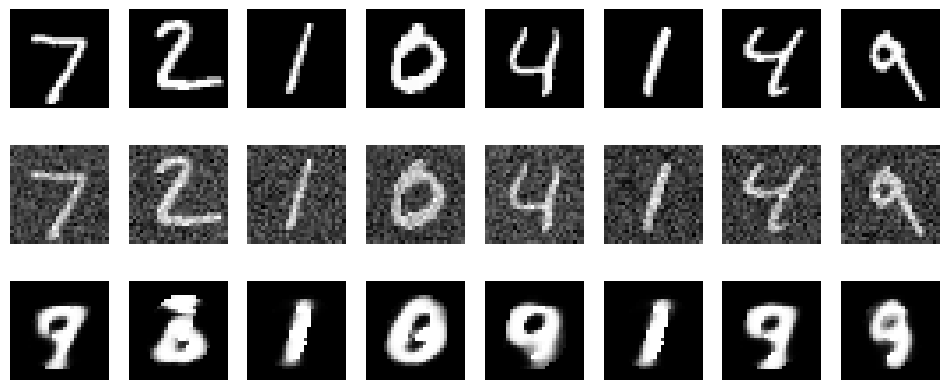

======================================== END RESULTS FOR lambda=5 ========================================

======================================== BEGINING RESULTS FOR lambda=0.0001 ========================================
Epoch [1/10], Loss: 0.8239
Epoch [2/10], Loss: 0.6830
Epoch [3/10], Loss: 0.6429
Epoch [4/10], Loss: 0.6219
Epoch [5/10], Loss: 0.6079
Epoch [6/10], Loss: 0.5985
Epoch [7/10], Loss: 0.5905
Epoch [8/10], Loss: 0.5837
Epoch [9/10], Loss: 0.5784
Epoch [10/10], Loss: 0.5742


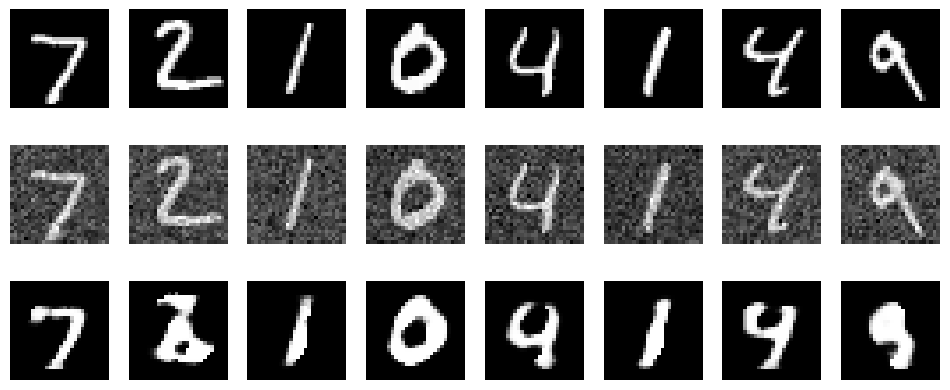

======================================== END RESULTS FOR lambda=0.0001 ========================================



In [ ]:
# Training function
for lambda_ in [5,  1e-4]:
    print('='*40,f'BEGINING RESULTS FOR lambda={lambda_}','='*40)
    model = ContractiveAutoencoder(input_dim, latent_dim, lambda_)
    optimizer = optim.Adam(model.parameters(), lr=0.0001)

    def train_model(model, optimizer, train_loader, test_loader, num_epochs=10, threshold=0.05):
        model.train()
        for epoch in range(num_epochs):
            running_loss = 0.0

            for inputs, _ in train_loader:
                inputs = inputs.view(inputs.size(0), -1)#.to(device)  # Flatten the input
                inputs.requires_grad = True  # Enable gradient computation for inputs

                optimizer.zero_grad()
                outputs, latent = model(inputs)
                loss = model.contractive_loss(inputs, outputs, latent)
                loss.backward()
                optimizer.step()
                running_loss += loss.item() * inputs.size(0)

            epoch_loss = running_loss / len(train_loader.dataset)


            print(f'Epoch [{epoch + 1}/{num_epochs}], Loss: {epoch_loss:.4f}')


    train_model(model, optimizer, train_loader, test_loader, num_epochs)


    with torch.no_grad():
        std = .5
        for data in test_loader:
            img, _ = data
            img = img.view(img.size(0), -1)
            img_noisy = img + torch.randn(img.size()) * std
            output, _ = model(img_noisy)
            # Plotting the first 8 test images and their reconstructions
            fig, axes = plt.subplots( 3, 8, figsize=(12, 5))
            for i in range(8):
                axes[0, i].imshow(img[i].view(28, 28).numpy(), cmap='gray')
                axes[1, i].imshow(img_noisy[i].view(28, 28).numpy(), cmap='gray')
                axes[2, i].imshow(output[i].view(28, 28).numpy(), cmap='gray')
                axes[0, i].axis('off')
                axes[1, i].axis('off')
                axes[2, i].axis('off')
            plt.show()
            break
    print('='*40,f'END RESULTS FOR lambda={lambda_}','='*40)
    print()

# Additional Experiments

## Fashion MNIST dataset

In [ ]:
# # Define hyperparameters
batch_size = 64
learning_rate = 1e-3
num_epochs = 10
noise_factor = 0.5

# Load and preprocess the FashionMNIST dataset
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.2860,), (0.3530,))
])

train_dataset = torchvision.datasets.FashionMNIST(root='./data', train=True, transform=transform, download=True)
test_dataset = torchvision.datasets.FashionMNIST(root='./data', train=False, transform=transform, download=True)

train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False)

100%|██████████| 26421880/26421880 [00:02<00:00, 12685606.73it/s]


Extracting ./data/FashionMNIST/raw/train-images-idx3-ubyte.gz to ./data/FashionMNIST/raw



100%|██████████| 29515/29515 [00:00<00:00, 198744.04it/s]


Extracting ./data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to ./data/FashionMNIST/raw



100%|██████████| 4422102/4422102 [00:01<00:00, 3691627.32it/s]


Extracting ./data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to ./data/FashionMNIST/raw



100%|██████████| 5148/5148 [00:00<00:00, 21252241.13it/s]

Extracting ./data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/FashionMNIST/raw



In [ ]:
# Function to plot images
def plot_images(images, titles, n_col=10):
    n_row = len(images) // n_col
    fig, axes = plt.subplots(n_row, n_col, figsize=(20, 4))
    for i, (img, title) in enumerate(zip(images, titles)):
        ax = axes[i // n_col, i % n_col]
        ax.imshow(img.squeeze(), cmap='gray')
        ax.set_title(title)
        ax.axis('off')
    plt.show()

In [ ]:
def add_gaussian_noise(x):
    return x + noise_factor * torch.randn_like(x)

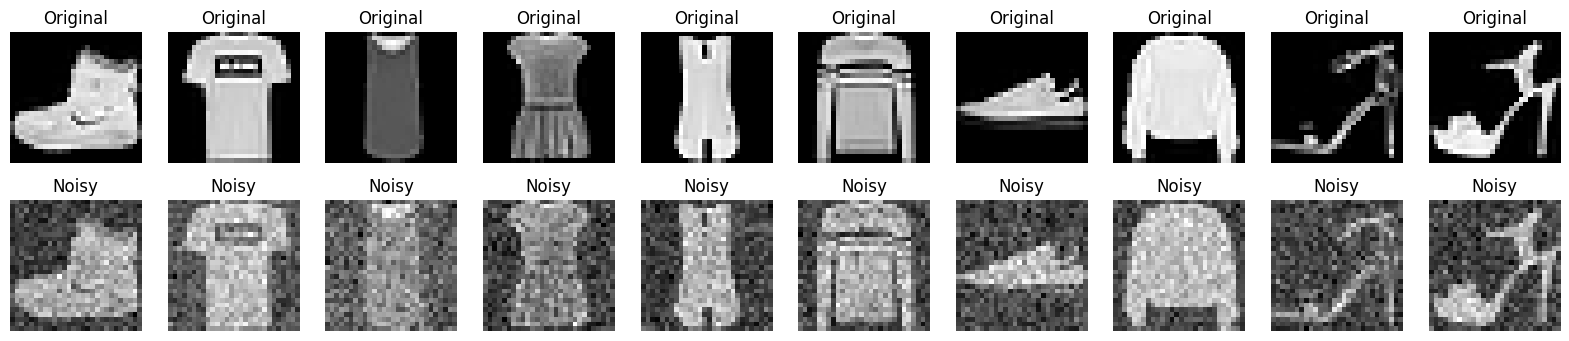

In [ ]:
n_samples = 20
original_images = []
noisy_images = []
titles = []

for i in range(n_samples):
    img, _ = train_dataset[i]
    noisy_img = add_gaussian_noise(img)

    original_images.append(img)
    noisy_images.append(noisy_img)
    titles.append("Original" if i < 10 else "Noisy")

# Combine images for plotting
images_to_plot = original_images[:10] + noisy_images[:10]

# Plot the images
plot_images(images_to_plot, titles)


In [ ]:
class DenoisingAutoencoder(nn.Module):
    def __init__(self):
        super(DenoisingAutoencoder, self).__init__()
        ## encoder layers ##
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 32, 3, padding=1),  # [batch, 1, 28, 28] -> [batch, 32, 28, 28]
            nn.ReLU(),
            nn.MaxPool2d(2, 2),              # [batch, 32, 28, 28] -> [batch, 32, 14, 14]
            nn.Conv2d(32, 16, 3, padding=1), # [batch, 32, 14, 14] -> [batch, 16, 14, 14]
            nn.ReLU(),
            nn.Conv2d(16, 8, 3, padding=1),  # [batch, 16, 14, 14] -> [batch, 8, 14, 14]
            nn.ReLU(),
            nn.MaxPool2d(2, 2)               # [batch, 8, 14, 14] -> [batch, 8, 7, 7]
        )

        ## decoder layers ##
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(8, 8, 3, stride=2, padding=1, output_padding=1),  # [batch, 8, 7, 7] -> [batch, 8, 14, 14]
            nn.ReLU(),
            nn.ConvTranspose2d(8, 16, 3, stride=2, padding=1, output_padding=1), # [batch, 8, 14, 14] -> [batch, 16, 28, 28]
            nn.ReLU(),
            nn.Conv2d(16, 1, 3, padding=1),                                       # [batch, 16, 28, 28] -> [batch, 1, 28, 28]
            nn.Sigmoid()
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x


In [ ]:
model = DenoisingAutoencoder().cuda()
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

In [ ]:
# Training loop
losses = []
for epoch in trange(num_epochs):
    model.train()
    for data in train_loader:
        img, _ = data
        img = img.cuda()
        noisy_img = add_gaussian_noise(img).cuda()

        # Forward pass
        outputs = model(noisy_img)
        loss = criterion(outputs, img)
        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    losses.append(loss.cpu().detach().numpy())

    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')

 10%|█         | 1/10 [00:17<02:34, 17.16s/it]

Epoch [1/10], Loss: 0.4922


 20%|██        | 2/10 [00:32<02:09, 16.19s/it]

Epoch [2/10], Loss: 0.4873


 30%|███       | 3/10 [00:49<01:54, 16.34s/it]

Epoch [3/10], Loss: 0.4482


 40%|████      | 4/10 [01:04<01:35, 15.98s/it]

Epoch [4/10], Loss: 0.4554


 50%|█████     | 5/10 [01:21<01:21, 16.26s/it]

Epoch [5/10], Loss: 0.4892


 60%|██████    | 6/10 [01:37<01:04, 16.09s/it]

Epoch [6/10], Loss: 0.4908


 70%|███████   | 7/10 [01:53<00:48, 16.22s/it]

Epoch [7/10], Loss: 0.4755


 80%|████████  | 8/10 [02:09<00:32, 16.14s/it]

Epoch [8/10], Loss: 0.4945


 90%|█████████ | 9/10 [02:25<00:16, 16.21s/it]

Epoch [9/10], Loss: 0.4700


100%|██████████| 10/10 [02:41<00:00, 16.15s/it]

Epoch [10/10], Loss: 0.4841


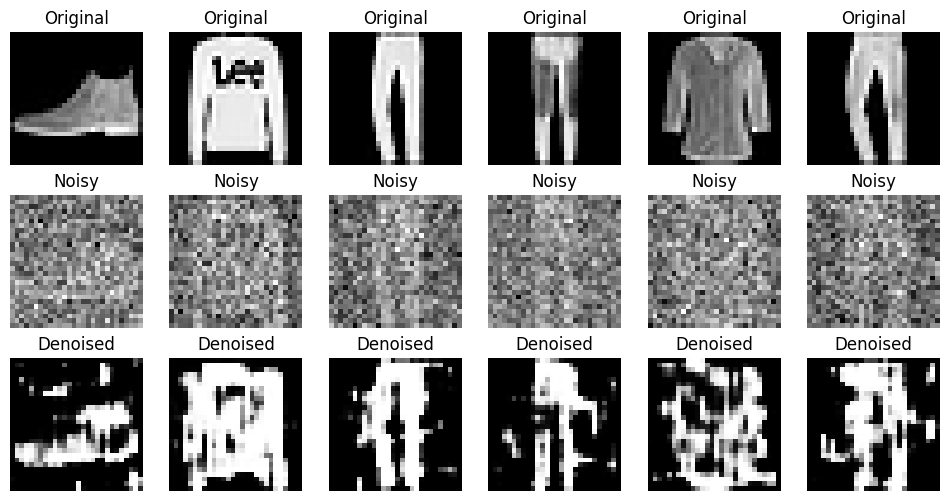

In [ ]:
# Testing loop for FashionMNIST
model.eval()
with torch.no_grad():
    for data in test_loader:
        img, _ = data
        img = img.cuda()
        noisy_img = (img + 2 * torch.randn_like(img)).cuda()
        outputs = model(noisy_img)

        # Visualize the results
        img = img.cpu().numpy()
        noisy_img = noisy_img.cpu().numpy()
        outputs = outputs.cpu().numpy()

        fig, axes = plt.subplots(3, 6, figsize=(12, 6))
        for i in range(6):
            axes[0, i].imshow(img[i].squeeze(), cmap='gray')
            axes[0, i].set_title('Original')
            axes[0, i].axis('off')
            axes[1, i].imshow(noisy_img[i].squeeze(), cmap='gray')
            axes[1, i].set_title('Noisy')
            axes[1, i].axis('off')
            axes[2, i].imshow(outputs[i].squeeze(), cmap='gray')
            axes[2, i].set_title('Denoised')
            axes[2, i].axis('off')
        plt.show()
        break

## Downstream tasks using features learned from the denoising autoencoder model

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

In [ ]:
# Extract features from the encoder
def extract_features(encoder, dataloader):
    features = []
    labels = []
    encoder.eval()
    with torch.no_grad():
        for img, label in dataloader:
            img = img.cuda()
            encoded = encoder(img).view(img.size(0), -1)
            features.append(encoded.cpu())
            labels.append(label)
    return torch.cat(features), torch.cat(labels)

train_features, train_labels = extract_features(model.encoder, train_loader)
test_features, test_labels = extract_features(model.encoder, test_loader)

In [ ]:
# Convert to numpy arrays
train_features_np = train_features.numpy()
train_labels_np = train_labels.numpy()
test_features_np = test_features.numpy()
test_labels_np = test_labels.numpy()

# Train a logistic regression classifier on the extracted features
classifier = LogisticRegression(max_iter=1000)
classifier.fit(train_features_np, train_labels_np)

# Predict on test data
test_preds = classifier.predict(test_features_np)
accuracy = accuracy_score(test_labels_np, test_preds)
print(f'Accuracy with Denoising Autoencoder: {accuracy:.4f}')


Accuracy with Denoising Autoencoder: 0.8600


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [ ]:
# Convert raw images to numpy arrays for the classifier
def images_to_numpy(dataloader):
    images = []
    labels = []
    for img, label in dataloader:
        images.append(img.view(img.size(0), -1))
        labels.append(label)
    return torch.cat(images).numpy(), torch.cat(labels).numpy()

train_images_np, train_labels_np = images_to_numpy(train_loader)
test_images_np, test_labels_np = images_to_numpy(test_loader)

# Train a logistic regression classifier on the raw data
classifier_raw = LogisticRegression(max_iter=1000)
classifier_raw.fit(train_images_np, train_labels_np)

# Predict on test data
test_preds_raw = classifier_raw.predict(test_images_np)
accuracy_raw = accuracy_score(test_labels_np, test_preds_raw)
print(f'Accuracy with Raw Data: {accuracy_raw:.4f}')


Accuracy with Raw Data: 0.8377


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


### Classification using a simpleCNN model to compare the results

In [ ]:
class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.fc1 = nn.Linear(64 * 7 * 7, 128)
        self.fc2 = nn.Linear(128, 10)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.pool(self.relu(self.conv1(x)))
        x = self.pool(self.relu(self.conv2(x)))
        x = x.view(-1, 64 * 7 * 7)
        x = self.relu(self.fc1(x))
        x = self.fc2(x)
        return x

# Initialize the network, loss function and optimizer
model = SimpleCNN().cuda()
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# Training loop
for epoch in range(num_epochs):
    model.train()
    for images, labels in train_loader:
        images, labels = images.cuda(), labels.cuda()
        noisy_img = add_gaussian_noise(images).cuda()
        outputs = model(noisy_img)

        loss = criterion(outputs, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')

# Evaluation
model.eval()
correct = 0
total = 0
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.cuda(), labels.cuda()
        noisy_img = add_gaussian_noise(images).cuda()
        outputs = model(noisy_img)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

accuracy_cnn = 100 * correct / total
print(f'Accuracy of the CNN on the Fashion MNIST test images: {accuracy_cnn:.2f}%')


Epoch [1/10], Loss: 0.6374
Epoch [2/10], Loss: 0.4348
Epoch [3/10], Loss: 0.2797
Epoch [4/10], Loss: 0.1334
Epoch [5/10], Loss: 0.5065
Epoch [6/10], Loss: 0.1914
Epoch [7/10], Loss: 0.2554
Epoch [8/10], Loss: 0.2468
Epoch [9/10], Loss: 0.1727
Epoch [10/10], Loss: 0.2244
Accuracy of the CNN on the Fashion MNIST test images: 89.46%
